In [1]:
import sys
sys.path
sys.executable
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Lambda, Conv2D, \
    MaxPooling2D, UpSampling2D,Input, Concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from data_utils import *

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [3]:
class UNet(object):
    def __init__(self, img_shape, num_of_class, actf = 'relu',
        learning_rate = 0.001,  drop_rate = 0.5, do_batch_norm = False, do_drop = False):

        '''
        Arguments :

        img_shape - shape of input image (64, 64, 1)
        actf - activation function for network training
        learning_rate - learning rate for training
        drop_rate - dropout rate
        do_batch_norm - whether to run for batchnormalization
        do_drop - whether to run for dropout
        '''

        self.learning_rate = learning_rate
        self.actf = actf
        self.img_shape = img_shape
        self.num_of_class = num_of_class
        self.drop_rate = drop_rate
        self.do_batch_norm = do_batch_norm
        self.do_drop = do_drop

        self.model = self.build_model()

    # encoding block(conv - conv - pool)
    def enc_conv_block(self, inputs, feature_maps, filter_size = (3, 3),
                           conv_strides = 1, pooling_filter_size = (2, 2), pooling_strides = (2, 2)):
        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool = MaxPooling2D(pooling_filter_size, strides = pooling_strides)(conv2)

        return pool, conv2

    # decoding block(concat - upconv - upconv)
    def dec_conv_block(self, inputs, merge_inputs, feature_maps, filter_size = (3, 3), conv_strides = 1,
                           up_conv_strides = (2, 2)):

        merge = Concatenate(axis = 3)([Conv2DTranspose(feature_maps, filter_size,
                                                       activation = self.actf, strides = up_conv_strides, kernel_initializer = 'he_normal',
                                                       padding = 'same')(inputs), merge_inputs])

        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(merge)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)

        return conv2

    # encoder
    def encoding_path(self, inputs):

        enc_conv1, concat1 = self.enc_conv_block(inputs, 64)
        enc_conv2, concat2 = self.enc_conv_block(enc_conv1, 128)
        enc_conv3, concat3 = self.enc_conv_block(enc_conv2, 256)
        enc_conv4, concat4 = self.enc_conv_block(enc_conv3, 512)

        return concat1, concat2, concat3, concat4, enc_conv4

    # decoder
    def decoding_path(self, dec_inputs, concat1, concat2, concat3, concat4):

        dec_conv1 = self.dec_conv_block(dec_inputs, concat4, 512)
        dec_conv2 = self.dec_conv_block(dec_conv1, concat3, 256)
        dec_conv3 = self.dec_conv_block(dec_conv2, concat2, 128)
        dec_conv4 = self.dec_conv_block(dec_conv3, concat1, 64)

        return dec_conv4
    # build network
    def build_model(self):
        inputs = Input(self.img_shape)

        # Contracting path
        concat1, concat2, concat3, concat4, enc_path = self.encoding_path(inputs)

        # middle path
        mid_path1 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(enc_path)
        mid_path1 = Dropout(self.drop_rate)(mid_path1)
        mid_path2 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(mid_path1)
        mid_path2 = Dropout(self.drop_rate)(mid_path2)

        # Expanding path
        dec_path = self.decoding_path(mid_path2, concat1, concat2, concat3, concat4)
        segmented = Conv2D(self.num_of_class, (1,1), activation ='sigmoid', padding = 'same', kernel_initializer = 'glorot_normal')(dec_path)


        model = Model(inputs = inputs, outputs = segmented)
        model.compile(optimizer = Adam(lr = self.learning_rate),
                          loss = 'binary_crossentropy', metrics = [dice_coef])

        return model

    # train model
    def train(self, X_train, Y_train, epoch = 10, batch_size = 32, val_split = 0.2, shuffle = True):

        
        earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
        checkpoint = ModelCheckpoint('checkpoint/model-{epoch:03d}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='min')  
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

        
        self.history = self.model.fit(X_train, Y_train, callbacks=[earlystopping,checkpoint,reduce_lr_loss ], validation_split = val_split,
                                          epochs = epoch, batch_size = batch_size, shuffle =  shuffle)
        return self.history

    # predict test data
    def predict(self, X_test):
        pred_classes = self.model.predict(X_test)

        return pred_classes

    # show u-net architecture
    def show_model(self):
        return print(self.model.summary())



# Load Data

In [5]:
x_train = np.load('/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/segmentation/dataset/x_train_512.npy')
y_train = np.load('/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/segmentation/dataset/y_train_512.npy')
x_test = np.load('/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/segmentation/dataset/x_test_512.npy')
y_test = np.load('/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/segmentation/dataset/y_test_512.npy')
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(966, 512, 512, 1) (966, 512, 512, 1)
(51, 512, 512, 1) (51, 512, 512, 1)


# Segmentation Class U-Net

In [6]:
seg_model = UNet(img_shape = (512,512,1), num_of_class = 1,learning_rate = 1e-5, do_drop = True, drop_rate = 0.5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
seg_model.show_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Train Model

In [65]:
history = seg_model.train(x_train, y_train, epoch = 100, batch_size = 4, val_split = 0.1)

Train on 869 samples, validate on 97 samples
Epoch 1/100
868/869 [============================>.] - ETA: 0s - loss: 0.3508 - dice_coef: 0.3078
Epoch 00001: val_loss improved from inf to 0.19799, saving model to checkpoint/model-001-0.197989.h5
869/869 [==============================] - 135s 156ms/sample - loss: 0.3506 - dice_coef: 0.3092 - val_loss: 0.1980 - val_dice_coef: 0.4679
Epoch 2/100
868/869 [============================>.] - ETA: 0s - loss: 0.1321 - dice_coef: 0.7198
Epoch 00002: val_loss improved from 0.19799 to 0.09575, saving model to checkpoint/model-002-0.095748.h5
869/869 [==============================] - 133s 153ms/sample - loss: 0.1321 - dice_coef: 0.7195 - val_loss: 0.0957 - val_dice_coef: 0.7840
Epoch 3/100
868/869 [============================>.] - ETA: 0s - loss: 0.0862 - dice_coef: 0.8369
Epoch 00003: val_loss improved from 0.09575 to 0.05816, saving model to checkpoint/model-003-0.058160.h5
869/869 [==============================] - 133s 153ms/sample - loss: 0.0

Epoch 27/100
868/869 [============================>.] - ETA: 0s - loss: 0.0203 - dice_coef: 0.9659
Epoch 00027: val_loss did not improve from 0.01886
869/869 [==============================] - 133s 153ms/sample - loss: 0.0203 - dice_coef: 0.9660 - val_loss: 0.0192 - val_dice_coef: 0.9494
Epoch 28/100
868/869 [============================>.] - ETA: 0s - loss: 0.0186 - dice_coef: 0.9692
Epoch 00028: val_loss improved from 0.01886 to 0.01443, saving model to checkpoint/model-028-0.014429.h5
869/869 [==============================] - 134s 155ms/sample - loss: 0.0186 - dice_coef: 0.9692 - val_loss: 0.0144 - val_dice_coef: 0.9703
Epoch 29/100
868/869 [============================>.] - ETA: 0s - loss: 0.0193 - dice_coef: 0.9690
Epoch 00029: val_loss did not improve from 0.01443
869/869 [==============================] - 134s 154ms/sample - loss: 0.0193 - dice_coef: 0.9691 - val_loss: 0.0185 - val_dice_coef: 0.9597
Epoch 30/100
868/869 [============================>.] - ETA: 0s - loss: 0.0180 

869/869 [==============================] - 132s 152ms/sample - loss: 0.0133 - dice_coef: 0.9784 - val_loss: 0.0122 - val_dice_coef: 0.9753
Epoch 54/100
868/869 [============================>.] - ETA: 0s - loss: 0.0132 - dice_coef: 0.9787
Epoch 00054: val_loss improved from 0.01218 to 0.01215, saving model to checkpoint/model-054-0.012151.h5
869/869 [==============================] - 132s 152ms/sample - loss: 0.0132 - dice_coef: 0.9786 - val_loss: 0.0122 - val_dice_coef: 0.9771
Epoch 55/100
868/869 [============================>.] - ETA: 0s - loss: 0.0131 - dice_coef: 0.9781
Epoch 00055: val_loss did not improve from 0.01215
869/869 [==============================] - 131s 151ms/sample - loss: 0.0131 - dice_coef: 0.9780 - val_loss: 0.0123 - val_dice_coef: 0.9766
Epoch 56/100
868/869 [============================>.] - ETA: 0s - loss: 0.0131 - dice_coef: 0.9787
Epoch 00056: val_loss did not improve from 0.01215
869/869 [==============================] - 131s 151ms/sample - loss: 0.0131 - d

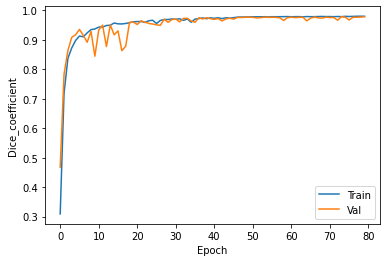

In [66]:
plot_dice(history)

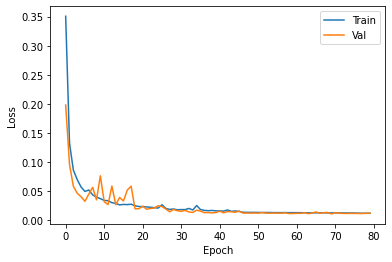

In [67]:
plot_loss(history)

# Show result

In [8]:
print(x_test.shape)
print(x_test[:10,:,:,:].shape)

(51, 512, 512, 1)
(10, 512, 512, 1)


In [89]:
seg_model.model.save('checkpoint/model-last.h5')

In [10]:
seg_model.model = keras.models.load_model('checkpoint/model-last.h5', custom_objects={"dice_coef": dice_coef})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
'''
# Option 1: Load with the custom_object argument.
seg_model.model  = keras.models.load_model(
    "checkpoint/model-070-0.010826.h5", custom_objects={"dice_coef": dice_coef}
)
'''

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
preds1 = seg_model.predict(x_test[:4,:,:,:])
preds2 = seg_model.predict(x_test[4:8,:,:,:])

In [12]:
print(preds1.shape)
print(preds2.shape)
preds = np.concatenate((preds1, preds2), axis=0)

(4, 512, 512, 1)
(4, 512, 512, 1)


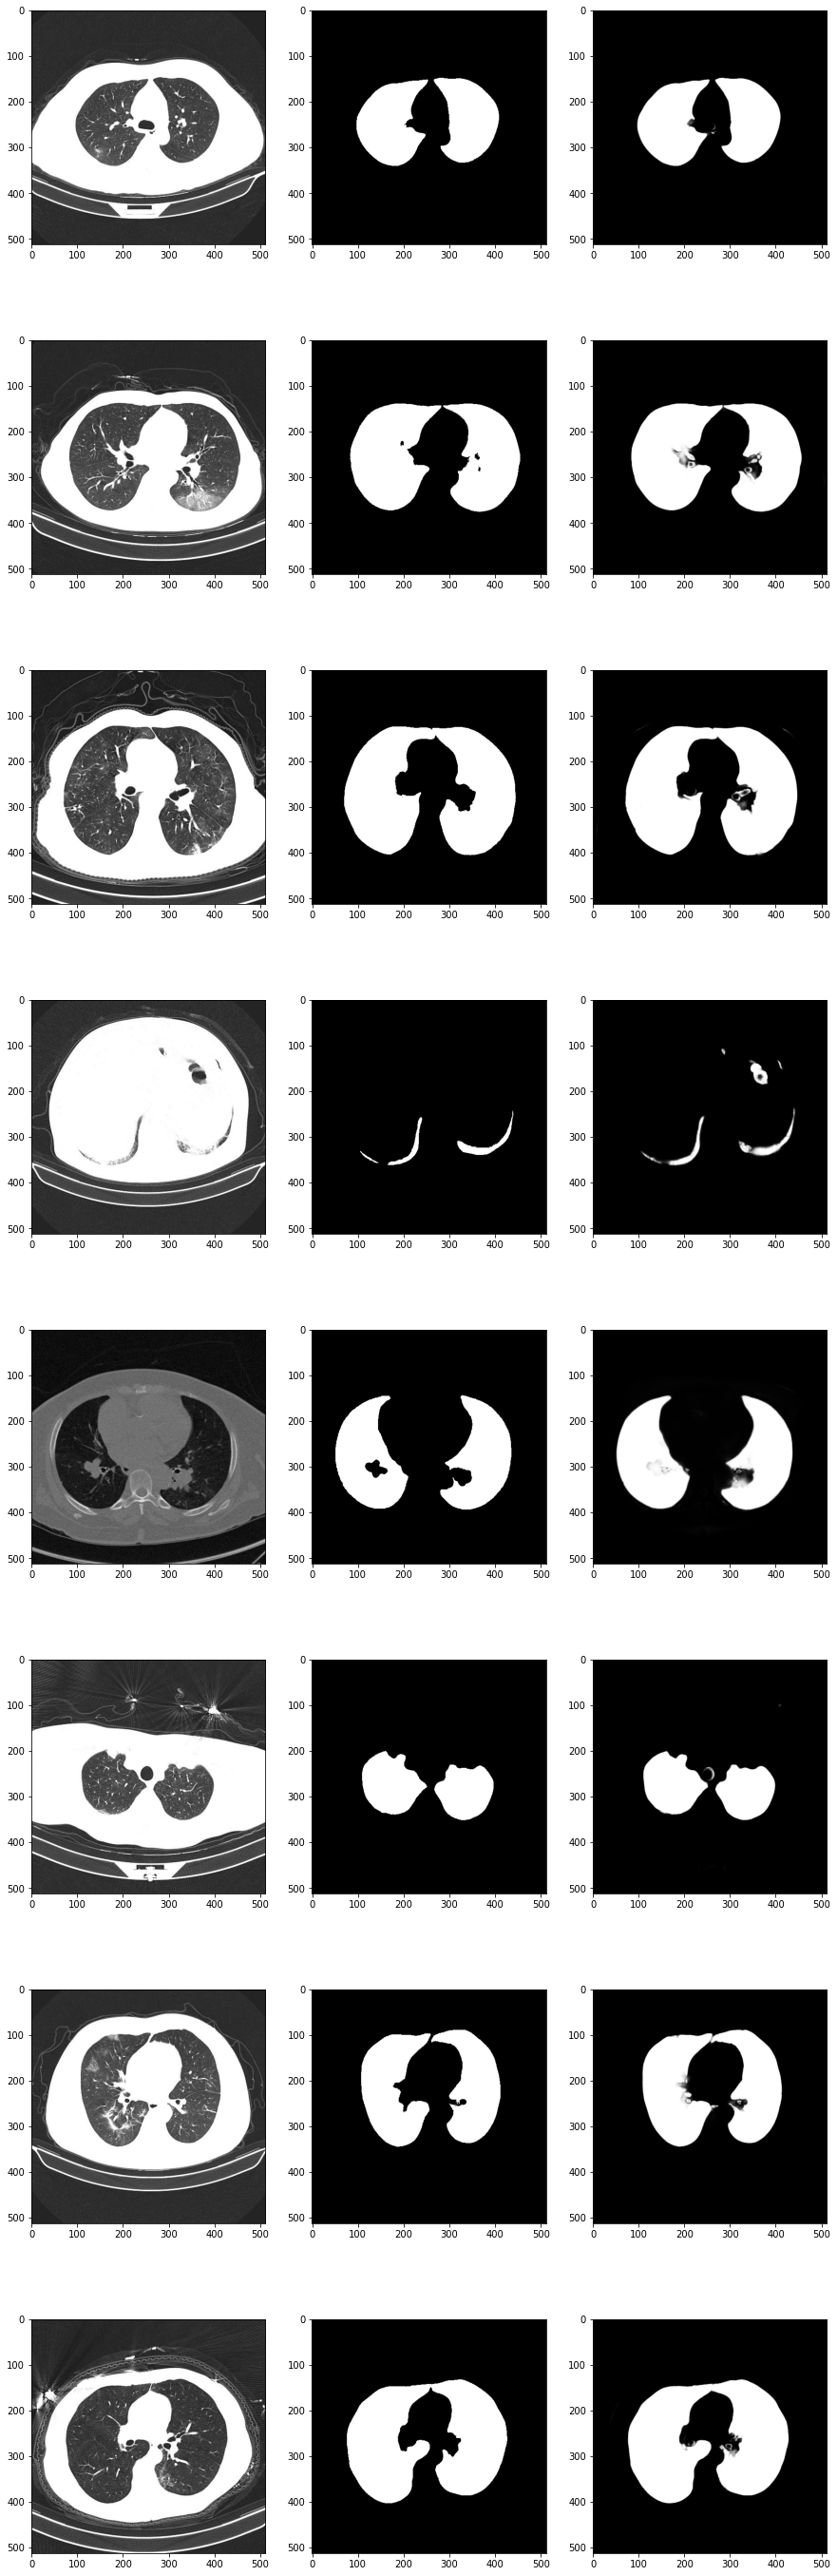

In [13]:
show_num = 8
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(preds[:show_num]):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')